In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `/Volumes/Chenyi/MIT/mosquito_inference/MosquitoProject`


In [2]:
using MosquitoProject, 
      StatsBase, Plots

default(grid=false,legend=false, size=(400,320), dpi=300, tickfontsize=16, lw=2, labelfontsize=16, tickdir=:out, fontfamily="Arial", legendfontsize=13)

In this script, we demonstrate how to perform dynamical model inference on experimental data of mosquito flight trajectories.

In [3]:
input_dir =  "../data/"
input_datafile = "11-22-24-Black-8in-CO2"

"11-22-24-Black-8in-CO2"

### Data processing

In [4]:
# # run this for the first time to create the jld files
# start_times, traces =  export_clean_traces(input_dir*input_datafile; min_start_time=300.0, max_start_time=Inf); # min_start_time=0.0, max_start_time=300

In [5]:
# load position, velocity, and time data
_pos, _vel, _t = jld_load_data(;
    data_dir = input_dir,
    file_name= input_datafile * "_clean_traces.jld", 
    diff_mode=:central2, len_scale=1.0, interp=false, dts=1.0, ndim=3
    );

In [6]:
N_DP = sum(length.(_t))
println("number of data points: ", sum(length.(_t)))
V_99 = partialsort( vcat([ sqrt.(sum(abs2, _vel[i], dims=2))[:,1] for i in eachindex(_vel)]...), floor(Int,(0.01*N_DP)), rev=true)[end]
println("99.5 percentile speed: ", V_99)

number of data points: 958456
99.5 percentile speed: 1.2212997907003091


### Visualization trajectory densities

In [7]:
CENTER_COORDS = [0.1 0.35 8.3]

1×3 Matrix{Float64}:
 0.1  0.35  8.3

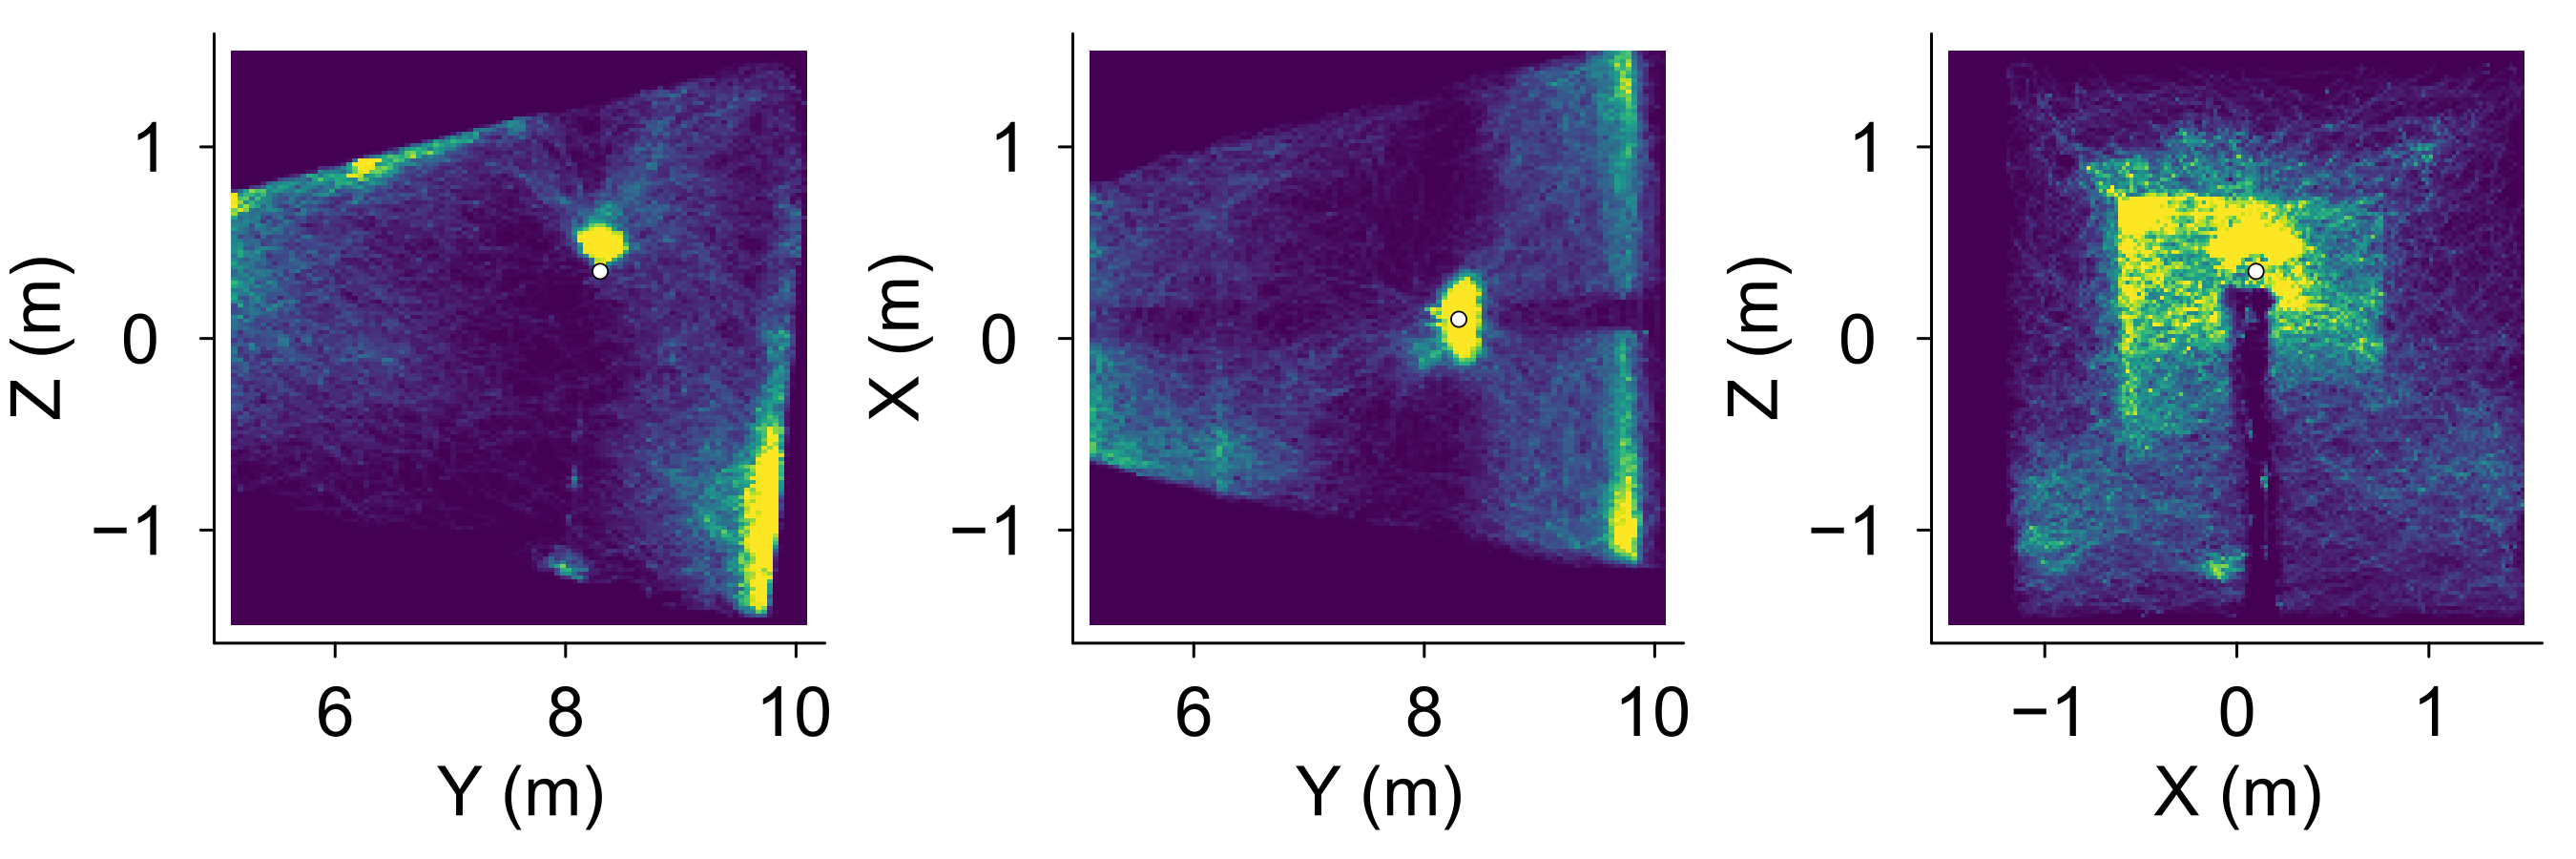

In [8]:
p_yz = histogram2d(vcat(_pos...)[:,3],vcat(_pos...)[:,2], show_empty=true, normalize=:pdf, cmap=:viridis,
    clim=(0,0.5), xlabel="Y (m)", ylabel="Z (m)", ytick=[-1,0,1,2], xtick=[6,8,10], bins=(collect(5.1:0.05:10.1), collect(-1.5:0.02:1.5)))
p_xz = histogram2d(vcat(_pos...)[:,3],vcat(_pos...)[:,1], show_empty=true, normalize=:pdf, cmap=:viridis,
    clim=(0,0.5), xlabel="Y (m)", ylabel="X (m)", ytick=[-1,0,1,2], xtick=[6,8,10], bins=(collect(5.1:0.05:10.1), collect(-1.5:0.02:1.5)))
p_xy = histogram2d(vcat(_pos...)[:,1],vcat(_pos...)[:,2], show_empty=true, normalize=:pdf, cmap=:viridis,
    clim=(0,0.5), xlabel="X (m)", ylabel="Z (m)", ytick=[-1,0,1,2], xtick=[-1,0,1,2], bins=(collect(-1.5:0.02:1.5), collect(-1.5:0.02:1.5)))
scatter!(p_yz, CENTER_COORDS[[3]],CENTER_COORDS[[2]], mc=:white, ms=3)
scatter!(p_xz, CENTER_COORDS[[3]],CENTER_COORDS[[1]], mc=:white, ms=3)
scatter!(p_xy, CENTER_COORDS[[1]],CENTER_COORDS[[2]], mc=:white, ms=3)
plot(p_yz, p_xz, p_xy, layout=(1,3), size=(900,300), bottommargin=10Plots.mm, leftmargin=5Plots.mm)
current()

### Filter trajectories
To avoid attraction to the boundaries, we select trajectories that are near the sphere.
In addition, to avoid tracking errors, we filter out trajectories that are too short.

In [9]:
function distance_to_center!(v, r; center_coords=CENTER_COORDS)
    fill!(v, 0.0)
    for k in 1:length(r)
        v[k] = r[k] - center_coords[k]
    end
    dd = mynorm(v)
    v ./= dd
    return dd
end

function filter_traj(pp::Vector{T1}, vv::Vector{T2}, tt::Vector{T3}; center_coords=[0.0,0.0,0.0],
    MAX_SPEED=Inf, MIN_SPEED=0.0, 
    MAX_TIME=Inf, MIN_TIME=0.0, 
    MAX_DIST=Inf, MIN_DIST=0.0) where {T1,T2,T3}

    tmp = zeros(length(center_coords));

    pp2 = Vector{T1}(undef, 0)
    vv2 = Vector{T2}(undef, 0)
    tt2 = Vector{T3}(undef, 0)

    sp = [ sqrt.(sum(abs2, vv[i], dims=2)) for i in eachindex(vv)];

    for i in eachindex(pp)
        dd_i = [distance_to_center!(tmp, pp[i][k,:]; center_coords=center_coords) for k in axes(pp[i],1)]
        select_i = (dd_i .> MIN_DIST) .& (dd_i .< MAX_DIST)
        (sum(select_i)==0) && (continue)
        # @show select_i
        start_i = findall(diff(vcat(false, select_i), dims=1) .> 0) 
        end_i = findall(diff(vcat(select_i, false), dims=1) .< 0)
        _, pick_i = findmax(end_i .- start_i)
        # @show pick_i
        ( (tt[i][end_i[pick_i]] - tt[i][start_i[pick_i]])  .< MIN_TIME ) && (continue)
        ( (tt[i][end_i[pick_i]] - tt[i][start_i[pick_i]])  .> MAX_TIME ) && (continue)
        any( sp[i][start_i[pick_i]:end_i[pick_i]] .> MAX_SPEED ) && (continue)
        any( sp[i][start_i[pick_i]:end_i[pick_i]] .< MIN_SPEED ) && (continue)
        push!(pp2, pp[i][start_i[pick_i]:end_i[pick_i],:])
        push!(vv2, vv[i][start_i[pick_i]:end_i[pick_i],:])
        push!(tt2, tt[i][start_i[pick_i]:end_i[pick_i]])
    end

    return pp2, vv2, tt2
end

filter_traj (generic function with 1 method)

In [10]:
_pos, _vel, _t = filter_traj(_pos, _vel, _t; 
                    center_coords=CENTER_COORDS, 
                    MAX_SPEED=1.6, MIN_TIME=1.0, MAX_DIST=0.75, MIN_DIST=0.05);

In [11]:
tmp = zeros(3)
_speed = [ sqrt.(sum(abs2, _vel[i], dims=2)) for i in eachindex(_vel)];
_dist = [ [distance_to_center!(tmp, _pos[j][i,:]) for i in 1:size(_pos[j],1)] for j in eachindex(_pos)]; 
_vdotd = [ sum( ( _pos[i] .- CENTER_COORDS ) .* (_vel[i]), dims=2 )[:] ./ _speed[i][:] ./ _dist[i][:] for i in eachindex(_pos)];

### Plot: trajectory density maps as functions of speed, distance, and flight direction

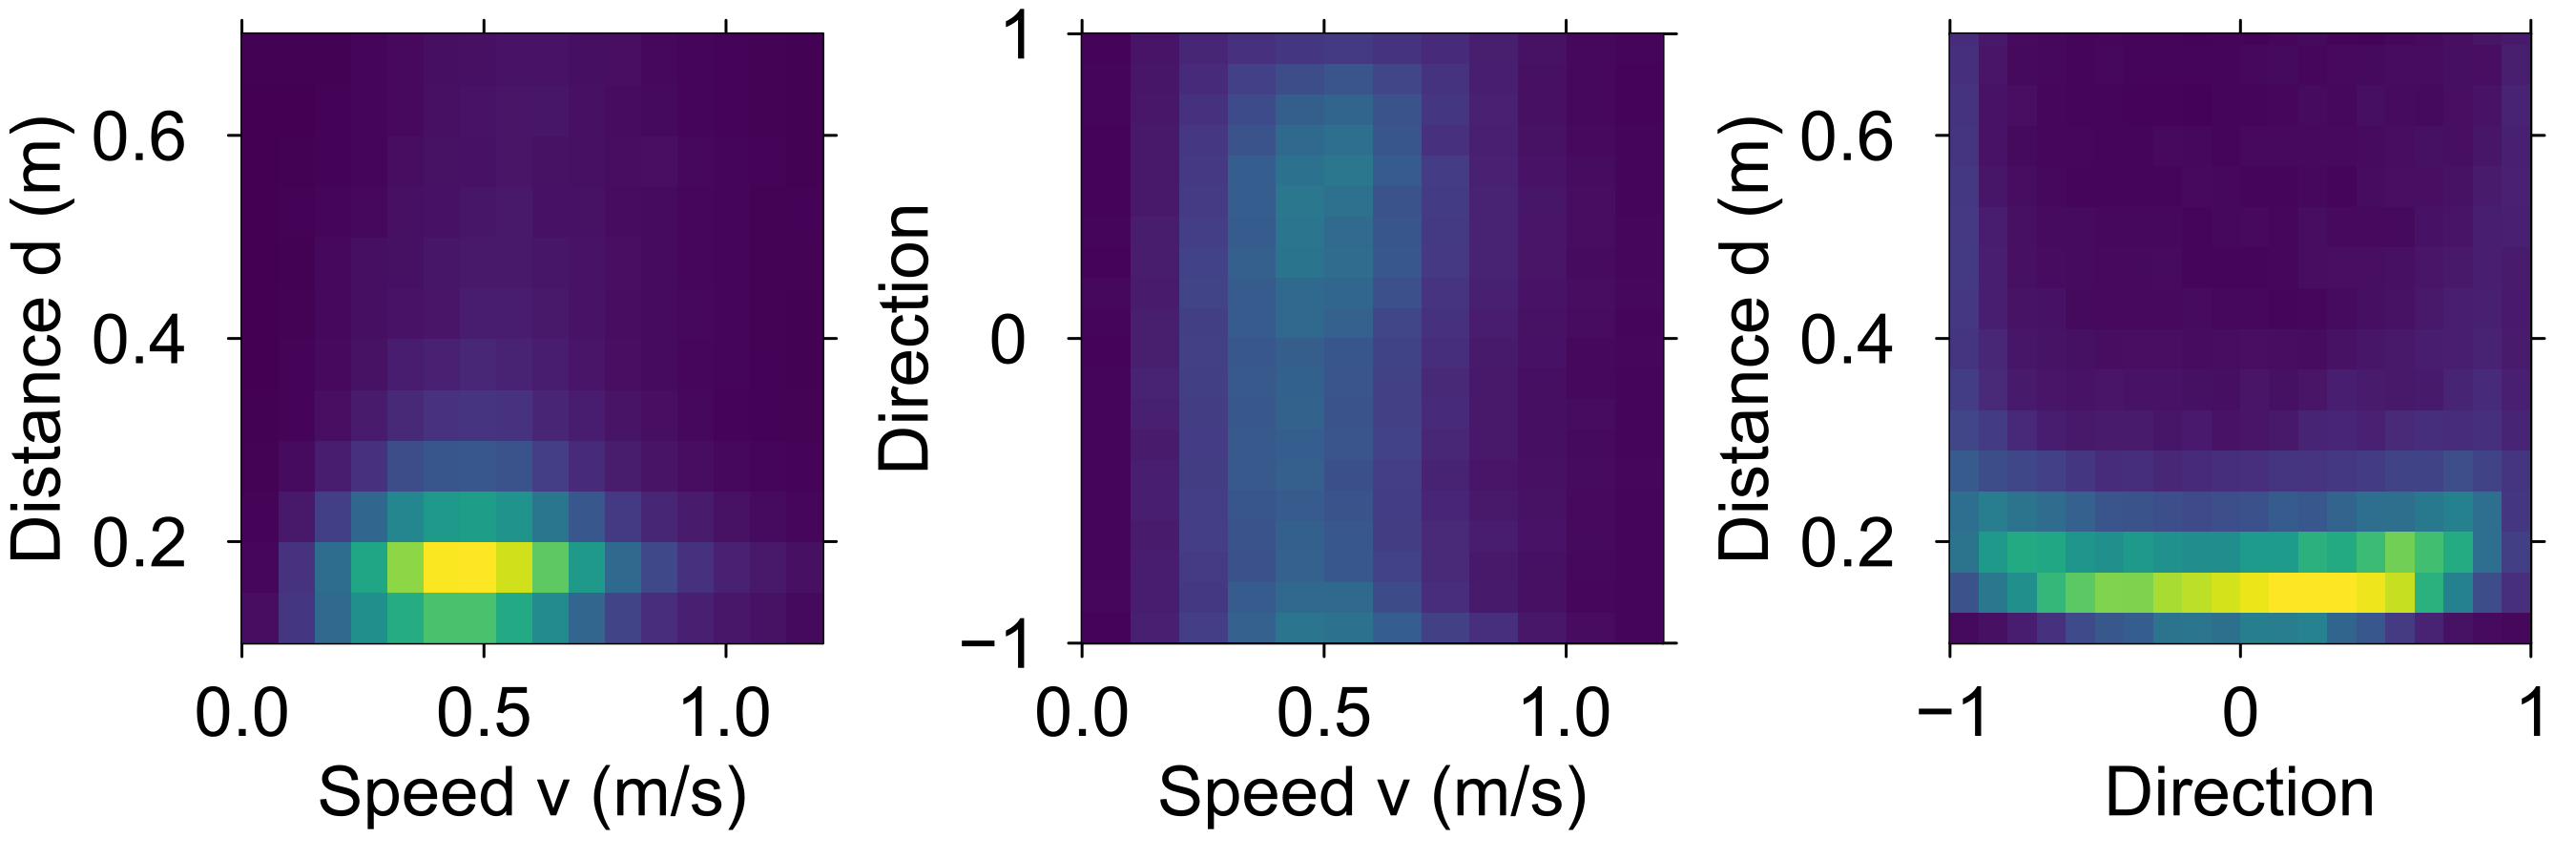

In [12]:
pExpTraj_vd = histogram2d(vcat(_speed...), vcat(_dist...), size=(300,280), normalize=:pdf, colormap=:viridis,
    show_empty=true, xlim=(0.,1.2), ylim=(0.1,0.7), clim=(0,12.0), bins=(collect(0:0.075:1.5), collect(0.05:0.05:1.0)),
    xlabel="Speed v (m/s)", ylabel="Distance d (m)",
    xtick = [0, 0.5, 1.0,1.5], ytick=[0.2, 0.4, 0.6], rightmargin=2Plots.mm, framestyle=:box,
)
pExpTraj_vdir = histogram2d(vcat(_speed...), vcat(_vdotd...), size=(300,280), normalize=:pdf, colormap=:viridis,
    show_empty=true, xlim=(0., 1.2), ylim=(-1.0,1.0), clim=(0,3),
    xlabel="Speed v (m/s)", ylabel="Direction", bins=(collect(0:0.1:1.5), collect(-1:0.1:1)),
    xtick = [0, 0.5, 1, 1.5], ytick=[-1.0, 0.0, 1.0], rightmargin=2Plots.mm, leftmargin=4Plots.mm, framestyle=:box
)

pExpTraj_dird = histogram2d(vcat(_vdotd...), vcat(_dist...), size=(300,280), normalize=:pdf, colormap=:viridis,
    show_empty=true, xlim=(-1., 1.0), ylim=(0.1,0.7), clim=(0,5.0),
    xlabel="Direction", ylabel="Distance d (m)", bins=(collect(-1:0.1:1), collect(0.05:0.04:0.85)),
    ytick=[0.2, 0.4, 0.6], xtick=[-1.0, 0.0, 1.0], rightmargin=2Plots.mm, framestyle=:box
)
plot(pExpTraj_vd, pExpTraj_vdir, pExpTraj_dird, layout=(1,3), size=(900,300), bottommargin=10Plots.mm, leftmargin=5Plots.mm)

### Learning mosquito's behavioral forces in response to visual and CO2 cues

In [13]:
# define model
function define_model(; ndim=3, f1=LaguerreFunction{Float64}(), n1=collect(0:5), p1=ones(1), c1=zeros(length(n1)), bfield1=nullfunc!,
                        f2a=LaguerreFunction{Float64}(), f2b=LaguerreFunction{Float64}(), f2ab=LegendreP{Float64}(),
                        n2a=collect(0:5), n2b=collect(0:5), n2ab=collect(0:5), c2=zeros(length(n2a)*length(n2b)*length(n2ab)),
                        p2=ones(2), bfield2=nullfunc! )
    
    model=MosquitoModel(; ndim=ndim, f1=f1, f2a=f2a, f2b=f2b, f2ab=f2ab);

    model.islearning[:visual] = true
    model.funcs[:visual] =  vcat( 
        vcat( 
        [ vcat( 
                [ vcat(
                        [Ψ2(f2a, f2b, f2ab, n2a_, n2b_, n2ab_, :ahat) for n2ab_ in n2ab]...
                      )  for n2b_ in n2b]... 
              ) for n2a_ in n2a]... 
        ),
        vcat( 
        [ vcat( 
                [ vcat(
                        [Ψ2(f2a, f2b, f2ab, n2a_, n2b_, n2ab_, :bhatorth2) for n2ab_ in n2ab]...
                      )  for n2b_ in n2b]... 
              ) for n2a_ in n2a]... 
        ),
    )
    model.coeffs[:visual] = zeros(length(model.funcs[:visual]))
    model.params[:visual] = p2;
    model.bfields[:visual] = bfield2
    
    return model

end

f_basis = LaguerreFunction{Float64}();
g_basis = LegendreP{Float64}();
model = define_model(; f2a=f_basis, f2b=f_basis, f2ab=g_basis, n2a=collect(0:3), n2b=collect(0:3), n2ab=collect(0:3),
                       bfield2 = distance_to_center!);

In [14]:
function inference_pipeline(x, v, t, model; force_type=:visual, min_cutoff=0.01, max_cutoff=1.0, n_cutoff = 10, dts=0.01)
    
    # initialize pipeline
    P = MosquitoInference(x, v, t, model);
    init_mosquitoinference(P);
    res = sparse_bayesian_fit(P, [1.0, 1.0], force_type; MAX_ITERS=50)
    
    D_learn = 0.0
    cutoffs = 10 .^ (range(log10(min_cutoff), log10(max_cutoff), length=n_cutoff))

     # sequential thresholding
    for cutoff in cutoffs
        
        println("cutoff = ", cutoff)
        
        count = 0
        while true
            coeffs_old = copy(P.coef_full);
            res_this = SBL( P.G[:, P.bigind], P.b, MAX_ITERS=20);
            fill!(P.coef_full, 0.0)
            copy!(@view(P.coef_full[P.bigind]), res_this[2])
            P.bigind = abs.(P.coef_full) .> cutoff;
            P.coef_full[.!(P.bigind)] .= 0.0;
            D_learn = exp(2*res_this[1])*dts
            println("itr=$count: n=$(sum(P.bigind)), D=$(exp(2*res_this[1])*dts)")
            count += 1
            if maximum(abs.(P.coef_full .- coeffs_old)) < 1e-6 || sum(P.bigind) == 0
                break
            end
        end

    end 

    model.coeffs[force_type] = P.coef_full;
    model.islearned[force_type] = true
    model.diffD = D_learn;
    
    nothing
end

inference_pipeline(_pos, _vel, _t, model; max_cutoff=0.3)

cutoff = 0.010000000000000002
itr=0: n=120, D=0.54949026170478
itr=1: n=119, D=0.5494919215140636
itr=2: n=119, D=0.549492247592844
itr=3: n=119, D=0.549492247592844
cutoff = 0.01459232802961085
itr=0: n=113, D=0.549492247592844
itr=1: n=112, D=0.549492219347855
itr=2: n=112, D=0.5494922207896886
itr=3: n=112, D=0.5494922207896886
cutoff = 0.021293603732376647
itr=0: n=109, D=0.5494922207896886
itr=1: n=106, D=0.5494923328270618
itr=2: n=104, D=0.5494923668057775
itr=3: n=104, D=0.5494936286850389
itr=4: n=104, D=0.5494936286850389
cutoff = 0.031072325059538584
itr=0: n=98, D=0.5494936286850389
itr=1: n=96, D=0.5494938071786168
itr=2: n=93, D=0.5494939206283769
itr=3: n=92, D=0.5494937719676918
itr=4: n=92, D=0.5494938743383336
itr=5: n=92, D=0.5494938743383336
cutoff = 0.045341755991148446
itr=0: n=81, D=0.5494938743383336
itr=1: n=76, D=0.5494920721922077
itr=2: n=72, D=0.5494924630931617
itr=3: n=71, D=0.5494925483418216
itr=4: n=71, D=0.5494893997182027
itr=5: n=71, D=0.54948939971

### Plot inferred forces

In [15]:
function fmag_learn(funcs, params, coeffs, vmag, dd, vd)
    f = 0.0
    for idx in eachindex(funcs)
        # fmag
        (typeof(funcs[idx])<:Ψ1) && ( fmag = term_mag(funcs[idx], vmag, params[1]))
        (typeof(funcs[idx])<:Ψ2) && ( fmag = term_mag(funcs[idx], vmag, dd, vd, params[1], params[2]) ) 
        f += coeffs[idx] * fmag
    end
    return f
end

function fmag_learn(v, d, vd, model; force_type=:visual, force_dir = :ahat)
    _select = [model.funcs[force_type][i].uvec == force_dir for i in eachindex(model.funcs[force_type])]
    f = [ fmag_learn(model.funcs[force_type][_select], model.params[force_type], model.coeffs[force_type][_select], v[k], d[i], vd[j]) 
    for i in eachindex(d), j in eachindex(vd), k in eachindex(v)];
    return f
end

fmag_learn (generic function with 2 methods)

In [16]:
v_array = collect(0.:0.02:1.2)
d_array = collect(0.:0.01:0.7)
vd_array = collect(-0.9:0.3:0.9)


f_parallel = fmag_learn(v_array, d_array, vd_array, model; force_type=:visual, force_dir=:ahat)
f_perpendicular = fmag_learn(v_array, d_array, vd_array, model; force_type=:visual, force_dir=:bhatorth2);

In [ ]:
function heatmap_flearn(f)
    p_all = []
    for n in axes(f, 2)
        p_this = heatmap(v_array, d_array, f[:,n,:], border=:box, xlim=(0.0,1.2),ylim=(0.0,0.7), size=(300,300),
            cb=:none, clim=(-4,4), xticks=[], yticks=[], color=:broc, title="v·d= $(vd_array[n])", titlefontsize=10,
        )
        push!(p_all, p_this)
    end
    plot(p_all..., layout=(1,length(vd_array)), size=(1050,150))
    return current()
end

heatmap_flearn (generic function with 1 method)

7


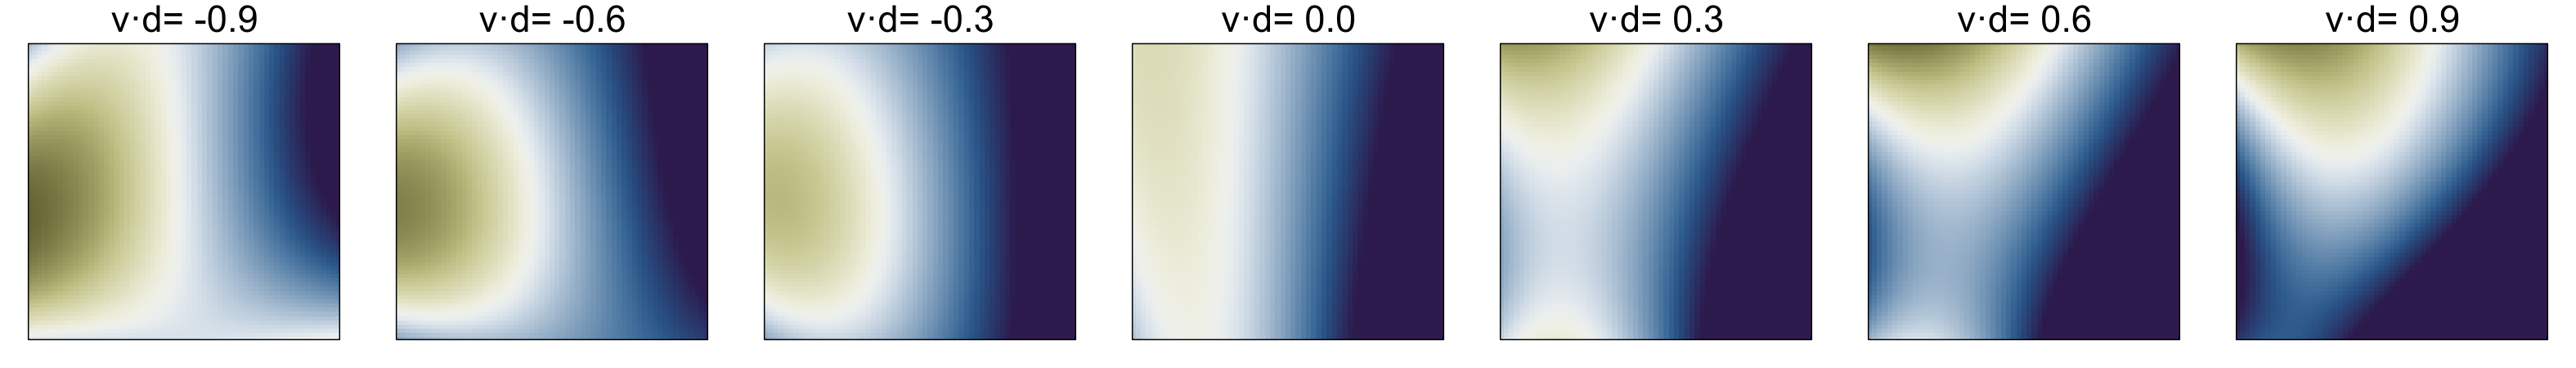

In [18]:
heatmap_flearn(f_parallel)

7


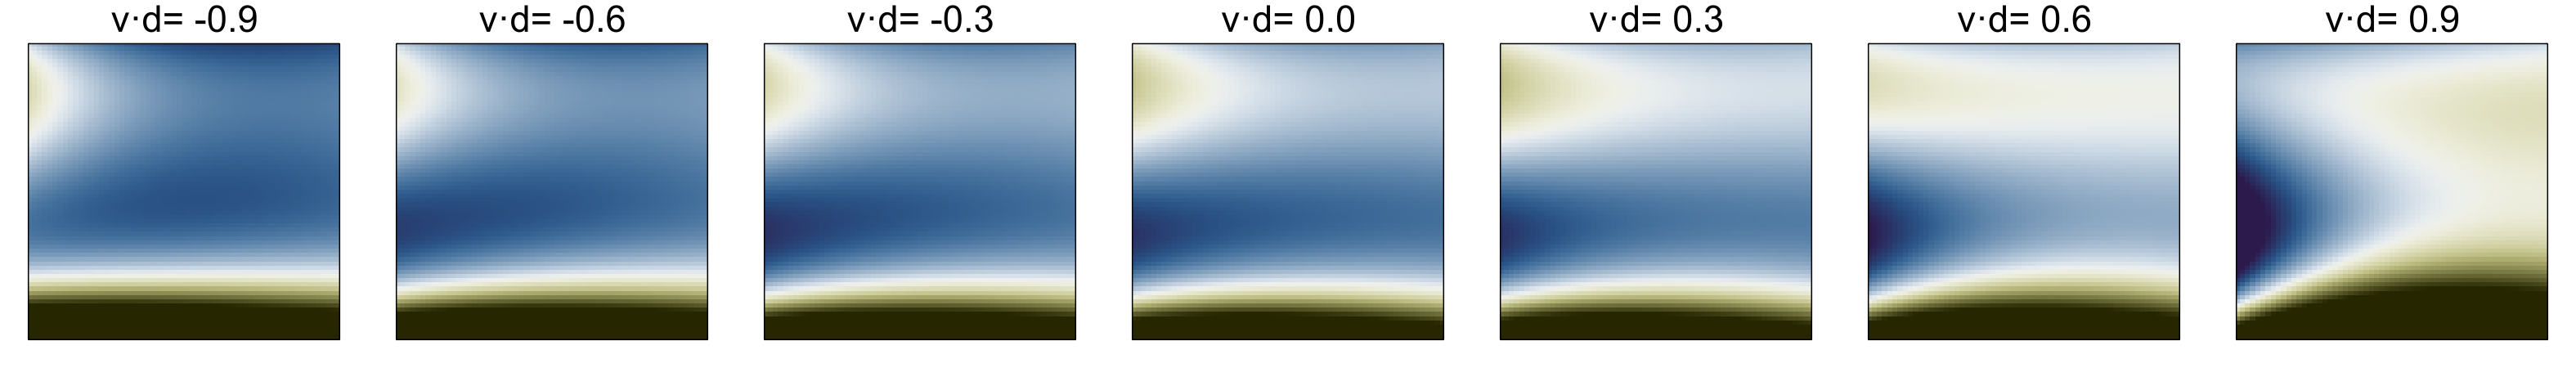

In [19]:
heatmap_flearn(f_perpendicular)